# Computational Methods in Simulation (CMIS) Week 6
This notebook is intended to support your learning process. It contains exercises that help you to understand the material. 

Background information:

Magnetization is explicitly induced by the relation
$$
  \begin{equation*}
    \vec B = \mu_0 \left(\vec M + \vec H\right)
  \end{equation*}
  $$
  The equation $\nabla \times \vec H = \vec 0$ has the general solution $\vec H = - \nabla \phi$ where $\phi$ is a scalar potential field. Now
  $$
  \begin{equation*}
    \vec B = \mu_0 \left(\vec M - \nabla \phi \right)
  \end{equation*}
  $$
  and by substitution
  $$
  \begin{equation*}
\nabla \cdot  \vec B = \mu_0 \left( \nabla \cdot \vec M - \nabla \cdot
  \nabla \phi  \right) = 0
  \end{equation*}
  $$
Cleaning up
$$
  \begin{equation*}
    \nabla \cdot  \nabla \phi = \nabla \cdot \vec M
  \end{equation*}
  $$
  This is a Poisson equation to solve for $\phi$.

This week is based in Slides 13 - follow the detailed steps below to learn about the finite volume method:

* Compute a solution $\phi(\vec x) : \Re^2 \mapsto \Re$ where $\vec x \in \Re^2$. The problem is $\nabla^2 \phi(\vec x) = \nabla \cdot \vec M(\vec x) \quad \forall \vec x \in  \mathcal{A}$ where $\mathcal{A}$ is the closed box $[-3..3] \times [-1..1]$ and $\vec M(\vec x) : \Re^2 \mapsto \Re^2$ is defined as zero outside the unit disk and $\vec M = (0, -1)^T$ everywhere else. At the vertex closest to the north pole of the unit disk boundary we have $\phi = 0$.  At every other boundary point of the box we have
$D( \phi, \vec n) = \nabla \phi^T \vec n = 0$ where $\vec n$ is the outward unit vector normal at the boundary. Remember that $\nabla^2 = \nabla \cdot \nabla$ and $\nabla = (\frac{\partial }{\partial x_1}, \frac{\partial }{\partial x_2})^T$.
* Derive and implement a finite volume method scheme (Hint: use FDM to approximate directional derivative $\nabla \phi(\vec x)^T \vec n$).
* Assume the domain can be ``nicely'' triangulated (use mesh from Week 3)
* Discuss grid layout and control volume types careful!
* If you have time try and change control volume to use a triangle control volume.

Hints: Think about how to deal properly with control volumes that are partial outside and inside the disk where $\vec M$ is defined. What is the problem with FVM for such control volumes?

## Detailed Expected Learning Objectives of this Week
  
* Account for Local and Global Conservation Properties of FVM.
* Explain the difference between FEM, FVM and FDM.
* Use Gauss-Divergence Principle to convert from volume to surface integrals.
* Exploit piece-wise continuous integrals.
* Apply numerical integration, ie mid-point rule, to surface integrals.
* Explain what a control volume is and how it relates to the computational mesh layout.

In [45]:
%matplotlib widget

In [46]:
import igl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.close('all')

Let's first define  our mesh. We'll define the same mesh as in our meshing exercise in week 3. However, we will make one change to the mesh generation to avoid any triangle ears in the computational mesh. The change consist in shifting the flip-flop patteren such that if an even number of nodes is used along $x$ and $y$ axes then the beam mesh will have no triangle ears.

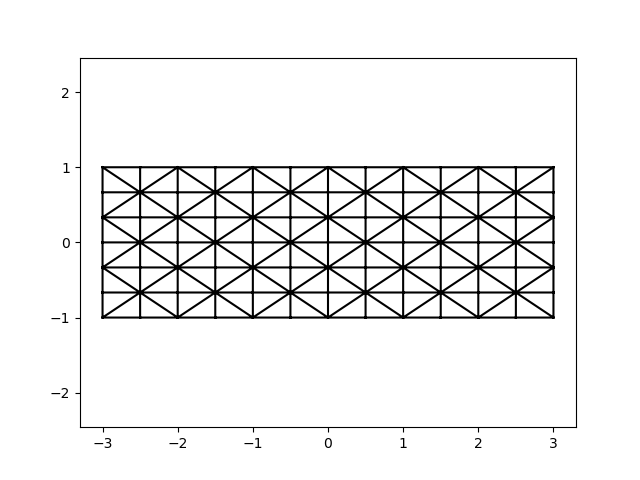

In [47]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

width = 6.0
height = 2.0
shape = (I,J) = (12,6)

V, T = make_beam_mesh(width, height, shape)

fig = plt.figure()
plt.triplot(V[:,0],V[:,1],T,color='k')
plt.axis('equal')
plt.show()

Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [48]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


class MeshInfo:
    
    def __init__(self, V, T):
        self.A = compute_triangle_areas(V, T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)

        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)

        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles (TT)
        self.VT = VT  # Triangle neighbors of vertices (VT)
        self.NI = NI  # Vertex neighbor indices (NI) used to extract triangle neighbors of vertices (VT)
        self.VV = VV  # Vertex neighbors of vertices (VV)
        self.bc = bc  # Barycenters of triangles (bc)

        mask = np.zeros(len(V),dtype=np.int32)
        mask[igl.boundary_loop(T)] = 1

        self.boundary_vertex = mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self,t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False

We will now run a simple test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

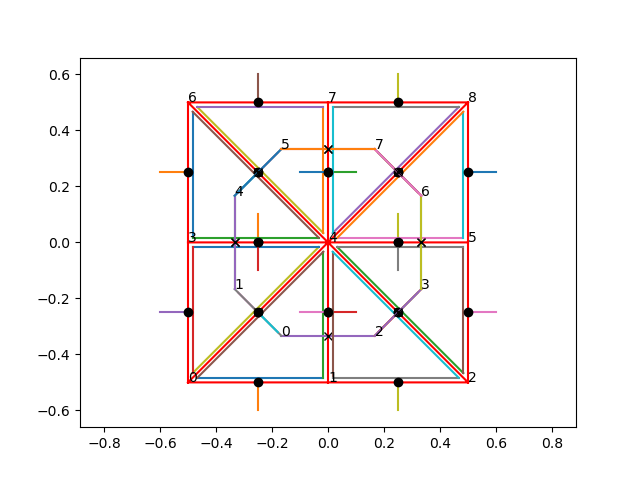

In [49]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')


for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0], info.V[v,1], str(v))
    
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))

for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))

for t in range(len(T)):
    c = info.get_triangle_center(t)
    
    for e in range(3):
        ### DRAW TRAINGLE EDGES ###
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )


        ### DRAW NORMALS ###
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')


        ### DRAW LINES BETWEEN TRIANGLE NEIGHBOR CENTERS ###
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')

plt.axis('equal')
plt.show()

# Creating Control Volume Data Structure

Our notation when visiting traingles in counter clock-wise order around vertex i. Here A is the first triangle in CCW order and B is the next triangle.

When we iterate over the triangles we will create the edges of the control volume one by one. We do this by looking ahead to the next triangle in CCW order and make the edge between the current and the next triangle centers. When we reach the last triangle in the neighbor we simply define the next triangle using the modulus operation. 

<pre>
        m
        *
       / \
      /   \  B   --- Next triangle when iterating over iterior triangles 
     /  x  \      
    /       \
   /         \
i *----------* k
   \        /
    \  x   /      
     \    /   A     --- Current triangle when iterating over iterior triangles
      \  /
       \/
       *
       j
</pre>

In cases where the control volume is not on the boundary all the neighbor triangles form a closed ring about the vertex center of the control volume. On the other hand if the control volume is on the boundary then the triangles do not loop around the vertex. In this case we sort the triangles in CCW order such that the first triangle is the start and the last is the end of the open neighborhood.

We need to treat the start and end triangles for boundary control volumes as special cases. In case of the first-triangle it will play the role of the B-triangle and a ghost triangle will play the role of A. For the last triangle it will pplay the role of an A triangle and the ghost will be a B-triangle.

<pre>
        
        *---------*
       / \        /
      /   \   x  /
     /  x  \    /  -- First CCW order triangle
    /       \  /
   /         \/ 
  *----------* i   -- Boundary vertex
   \        /
    \  x   /      
     \    /  --- Last CCW order triangle
      \  /
       \/
       *
       
</pre>

Having this logic defined it is a simple matter of generating the control volume boundary.

For the start/end triangles we define the CV edges to run from center of the triangle orthogonal to the physical boundary of the domain and then from the boundary intersection point back the control volume center.

In [50]:
def project_to_line(q, pi, pj):
    u = pj -pi
    l = np.linalg.norm(u)
    u = u/l
    return np.dot(q-pi, u)*u + pi
    
    
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):    
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int32).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int32 )
        prev_order = -np.ones( (len(T), ), dtype=np.int32 )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int32).flatten()
    return ccw_order

    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.boundary = info.is_boundary_vertex(v)
        
        labels = info.get_triangles_of_vertex(v)
        
        T = info.T[labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])
            
        ccw_order = get_ccw_triangle_order(v, T)
        T = T[ccw_order,:]
        labels = labels[ccw_order]
        
        self.M = []  # Edge mid-points
        self.E = []  # Edge vectors
        self.L = []  # Edge length
        self.N = []  # Outward unit-normal for edge
        self.S = []  # Segment between opposite CV center and this CV center
        self.opp = [] # Index of CV opposite this CV across the edge
        self.code = [] # A code flag that encodes what type of edge we have, 0:interior, 1:boundary, 2:from interior to boundary (semi-interior)
        
        self.INTERIOR = 0
        self.BOUNDARY = 1
        self.SEMI_INTERIOR = 2
        
        if self.boundary:
            # First CCW triangle. In this case the triangle has
            # the B-role and the Ghost triangle has the A-role
            i = T[0,0]
            k = T[0,1]
            B = labels[0]
            cB = info.get_triangle_center(B)
            pi = info.V[i,:]
            pk = info.V[k,:]
            cA = project_to_line(cB,pi,pk)
            
            m = (cA+pi)/2
            u = cA-pi
            l = np.linalg.norm(u)
            n = -hat(u)/l
            s = vec2(0,0)
            self.M.append(m)
            self.E.append(u)
            self.L.append(l)
            self.N.append(n)
            self.S.append(s)
            self.opp.append(-1)
            self.code.append(self.BOUNDARY)
                                    
            m = (cA+cB)/2
            u = cB-cA
            l = np.linalg.norm(u)
            n = -hat(u)/l
            s = pk-pi
            self.M.append(m)
            self.E.append(u)
            self.L.append(l)
            self.N.append(n)
            self.S.append(s)
            self.opp.append(k)
            self.code.append(self.SEMI_INTERIOR)
            
        K = len(labels)
        endK = K
        if self.boundary:
            # When we have an open boundary we must
            # be careful not trying to "close" the neighborhood
            # when generating interior edges    
            endK = K-1  
                
        for e in range(endK):
            i = T[e,0]
            k = T[e,2]
            A = labels[e]
            B = labels[(e+1)%K]
            
            cA = info.get_triangle_center(A)
            cB = info.get_triangle_center(B)
                
            m = (cA+cB)/2
            u = cB-cA
            l = np.linalg.norm(u)
            n = -hat(u)/l
                
            pi = info.V[i,:]
            pk = info.V[k,:]
            s = pk-pi
            
            self.M.append(m)
            self.E.append(u)
            self.L.append(l)
            self.N.append(n)
            self.S.append(s)
            self.opp.append(k)
            self.code.append(self.INTERIOR)
            
        if self.boundary:
            # Last CCW triangle. In this case the triangle has
            # the A-role and the Ghost triangle has the B-role            
            i = T[endK,0]
            k = T[endK,2]
            A = labels[endK]
            cA = info.get_triangle_center(A) 
            pi = info.V[i,:]
            pk = info.V[k,:]
            cB = project_to_line(cA,pi,pk)
                                                            
            m = (cA+cB)/2           # Edge mid-point
            u = cB-cA               # Edge vector
            l = np.linalg.norm(u)   # Edge length
            n = -hat(u)/l           # Outward unit normal for edge                
            s = pk-pi               # Segment between opposite CV center and this CV center            
            self.M.append(m)
            self.E.append(u)
            self.L.append(l)
            self.N.append(n)
            self.S.append(s)
            self.opp.append(k)
            self.code.append(self.SEMI_INTERIOR)
            
            m = (pi+cB)/2           # Edge mid-point
            u = pi-cB               # Edge vector
            l = np.linalg.norm(u)   # Edge length
            n = -hat(u)/l           # Outward unit normal for edge                
            s = vec2(0,0)           # Segment between opposite CV center and this CV center            
            self.M.append(m)
            self.E.append(u)
            self.L.append(l)
            self.N.append(n)
            self.S.append(s)
            self.opp.append(-1)
            self.code.append(self.BOUNDARY)

        self.M = np.array(self.M, dtype=np.float32)
        self.E = np.array(self.E, dtype=np.float32)
        self.L = np.array(self.L, dtype=np.float32)
        self.N = np.array(self.N, dtype=np.float32)
        self.S = np.array(self.S, dtype=np.float32)
        self.opp = np.array(self.opp, dtype=np.int32)
        self.code = np.array(self.code, dtype=np.int32)

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

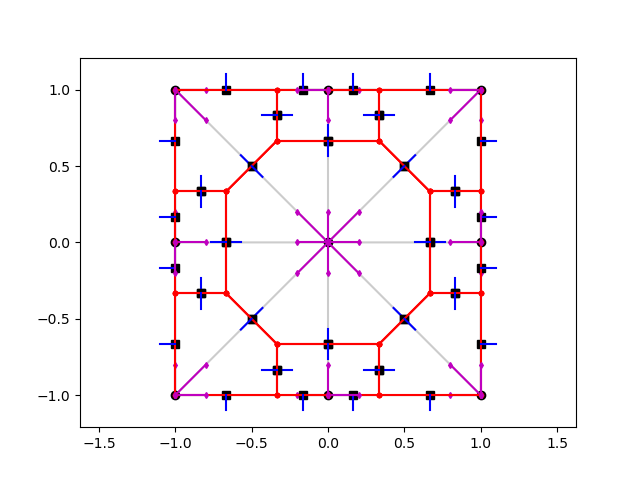

In [51]:
V, T = make_beam_mesh(2.0,2.0,(2,2))
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='k', linestyle='-', alpha = 0.2)

for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    
    for e in range(len(cv.code)):
        plt.plot(cv.M[e,0],cv.M[e,1],'ks')
        start = cv.M[e,:] - cv.E[e,:]/2
        end = cv.M[e,:] + cv.E[e,:]/2        
        start = (start - cv.c)*1.0 + cv.c
        end = (end - cv.c)*1.0 + cv.c
        plt.plot([start[0], end[0]],[start[1], end[1]],'-ro', ms=3)
                   
        start = cv.M[e,:] 
        end = cv.M[e,:] + cv.N[e,:]*0.1
        start = (start - cv.c)*1.0 + cv.c
        end = (end - cv.c)*1.0 + cv.c
        plt.plot([start[0], end[0]],[start[1], end[1]],'-b')

        start = cv.c 
        end = cv.c + cv.S[e,:]*0.2
        plt.plot([start[0], end[0]],[start[1], end[1]],'-md', ms = 3)
ax.axis('equal')
plt.show()

# Finite Volume Method for Magnetostatic Problem

Now when we have created our control volume data structure we can start assembling a matrix systetm that we can solve.

The assembly method returns the A-matrix and b-vector for the full system. It also returns the index of the north pole node where the Dirichlet condition is applied. Further the assembly method applies the boundary condition to the full system before it returns its values.

In [52]:
def inside_unit_circle(p):
    return np.linalg.norm(p) <= 1


def matrix_assembly(CVs):
    N = len(CVs)
    A = np.zeros((N,N),dtype=np.float32)
    b = np.zeros((N,),dtype=np.float32)
    
    idx_NP = 0
    north_pole = vec2(0,1)
    min_dist = np.linalg.norm(north_pole - CVs[0].c)
    
    for c in range(N):        
        cv = CVs[c]
                
        dist = np.linalg.norm(north_pole - cv.c)
        if dist < min_dist:
            min_dist = dist
            idx_NP = c
        
        for e in range(len(cv.code)):
            n = cv.N[e,:]
            m = cv.M[e,:]
            l = cv.L[e]
            s = cv.S[e,:]
            k = cv.opp[e]
            code = cv.code[e]
            M = vec2(0,0)
            
            # TODO - Add your solution for computing M field
            if inside_unit_circle(m):
                M = vec2(0, -1)
                
            if code == cv.INTERIOR:
                # edge is inside domain and everything is fine, and we can use
                # 'straightforward' discretization
                A[c,c] -= l/np.linalg.norm(s)
                A[c,k] = l/np.linalg.norm(s)
                b[c] += np.dot(M,n)*l

            if code == cv.SEMI_INTERIOR:
            #     edge is coming from inside domain and ends on the physical
            #     boundary -- we must apply some special discretization
                A[c,c] -= l*2/np.linalg.norm(s)
                A[c,k] = l*2/np.linalg.norm(s)
                b[c] += np.dot(M,n)*l

            if code == cv.BOUNDARY:
                # edge is on the physical boundary -- we must apply some boundary condition, here we got von Neumann condition saying nabla phi dot n = 0  
                A[c,c] += 0
                A[c,k] += 0
                b[c] += 0
            
                
    # Add a Dirichlet condition to node that is closest to the North Pole (0,1)
    # TODO - Add your solution here
    φ_boundary = 0
    A[:,idx_NP] = 0
    A[idx_NP,:] = 0
    A[idx_NP,idx_NP] = 1 
    b[idx_NP] = φ_boundary
    
    return A, b, idx_NP

We now have all code pieces in place to create all the control volumes and perform our assembly process to create a final matrix system that can be solved later on.

In [53]:
V, T = make_beam_mesh(6.0, 2.0, (72, 24))
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)  

A, b, idx = matrix_assembly(CVs)

Before we continue with solving our system we will briefly inspect if the system matrix having the correct fill pattern and eigenvalues as we would expect.

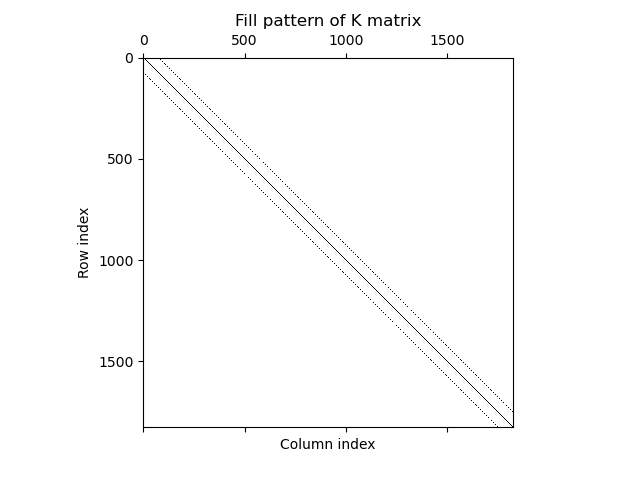

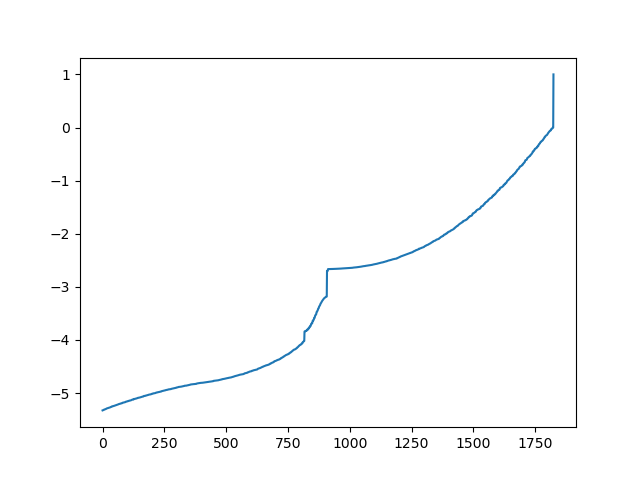

In [54]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(A);
ax.set_title('Fill pattern of K matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
plt.show()

fig = plt.figure()
d, _ = np.linalg.eig(A)
plt.plot(np.sort( d ) );
ax.set_title('Eigenvalues of K matrix');
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value');
plt.show()

After we have verified that the assembly was done correctly we can now compute our solution. After the solution we just verify if our boundary condition was treated correctly

In [55]:
phi = np.linalg.solve(A, b)

print('North pole node was located at ',CVs[idx].c, ' and has phi-value = ',phi[idx])

North pole node was located at  [0. 1.]  and has phi-value =  0.0


Let us now plot our solution to verify if it behaves as we expect

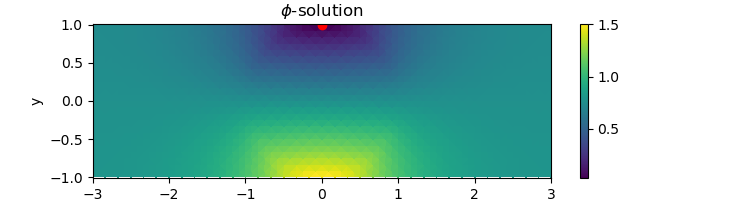

In [56]:
fig = plt.figure(figsize=(7.4, 2))
ax = plt.subplot(111)
plt.tripcolor(V[:,0],V[:,1],T,phi)
plt.plot(CVs[idx].c[0],CVs[idx].c[1],'ro')
plt.colorbar()
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-3,3])
ax.set_ylim([-1,1])
ax.set_title('$\phi$-solution')
plt.show()

It can be insightful to see a potential field as a height field in 3D

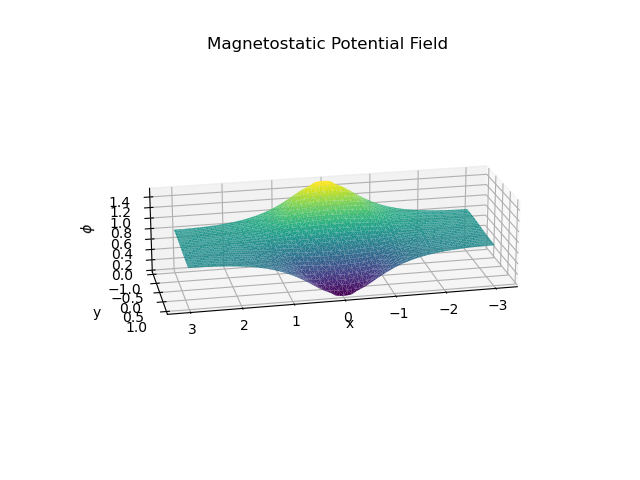

In [79]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y, Z  = V[:,0], V[:,1], phi
ax.plot_trisurf(X, Y, Z,  triangles=T, linewidth=0.2, antialiased=True, cmap=plt.cm.viridis)
ax.set_box_aspect([np.ptp(a) for a in [X, Y, Z]])
# change rotation angle
ax.view_init(20, 78)

ax.set_title('Magnetostatic Potential Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\phi$')
ax.set_aspect('auto')
plt.show()

Another usefull visualization technique is to show contours of the solution. 

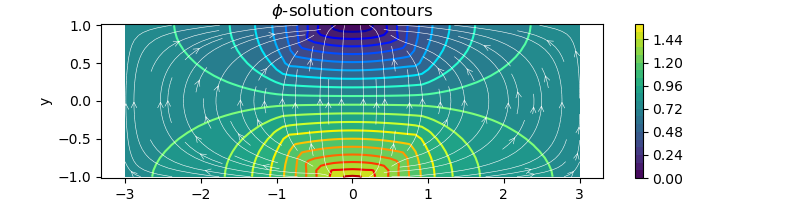

In [70]:
fig = plt.figure(figsize=(8.1, 2))
ax = plt.subplot(111)
X = V[:,0].reshape(25,73)
Y = V[:,1].reshape(25,73)
Z = phi.reshape(25,73)

# add magnetic field streamlines
gy, gx = np.gradient(-Z)
plt.contourf(X,Y,Z,levels=20)
plt.colorbar()
plt.contour(X,Y,Z,levels=20,cmap=plt.cm.jet)
plt.streamplot(X, Y, gx, gy, color = 'white', arrowstyle='->', linewidth=0.4)

ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('$\phi$-solution contours')
plt.show()

That is all folks!